In [1]:
# Load the JSON data and preview its structure
import json

with open('session.json', 'r') as f:
    session_data = json.load(f)

# Preview the data structure
print(type(session_data))
if isinstance(session_data, dict):
    print(session_data.keys())
elif isinstance(session_data, list):
    print(session_data[:2])
else:
    print(session_data)

<class 'dict'>
dict_keys(['session_id', 'surface_id', 'surface_type', 'room_id', 'cleaner_id', 'start_time', 'end_time', 'grid_h', 'grid_w', 'coverage_count_grid', 'high_touch_mask', 'wipe_events', 'camera_id'])


In [2]:
# Inspect grid-based fields for contamination risk analysis
import numpy as np

grid_h = session_data.get('grid_h')
grid_w = session_data.get('grid_w')
cov_grid = session_data.get('coverage_count_grid')
high_touch_mask = session_data.get('high_touch_mask')

print('Grid shape:', grid_h, grid_w)
print('Sample coverage_count_grid:', cov_grid[:2] if cov_grid else None)
print('Sample high_touch_mask:', high_touch_mask[:2] if high_touch_mask else None)

# Convert to numpy arrays for easier exploration, if available
if cov_grid:
    cov_arr = np.array(cov_grid)
    print('Coverage grid array shape:', cov_arr.shape)
    print('Coverage grid sample:', cov_arr[:3])
if high_touch_mask:
    ht_arr = np.array(high_touch_mask)
    print('High touch mask array shape:', ht_arr.shape)
    print('High touch mask sample:', ht_arr[:3])

Grid shape: 3 4
Sample coverage_count_grid: [[0, 1, 0, 0], [1, 2, 0, 0]]
Sample high_touch_mask: [[0, 1, 1, 0], [0, 1, 1, 0]]
Coverage grid array shape: (3, 4)
Coverage grid sample: [[0 1 0 0]
 [1 2 0 0]
 [0 0 0 4]]
High touch mask array shape: (3, 4)
High touch mask sample: [[0 1 1 0]
 [0 1 1 0]
 [0 0 0 0]]


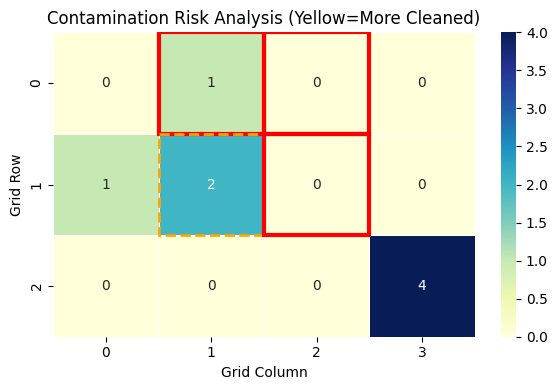

In [5]:
# Visualize contamination risk: heatmap of coverage, overlay high-touch with risk highlights
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 4))

# Coverage grid heatmap
sns.heatmap(cov_arr, annot=True, fmt='d', cmap='YlGnBu', cbar=True, ax=ax, linewidths=0.5)

# Overlay high-touch mask: red squares
for i in range(ht_arr.shape[0]):
    for j in range(ht_arr.shape[1]):
        if ht_arr[i, j] == 1 and cov_arr[i, j] <= 1:  # Risk: high-touch and low cleaning
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=3))
        elif ht_arr[i, j] == 1:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='orange', lw=2, linestyle='--'))

ax.set_title('Contamination Risk Analysis (Yellow=More Cleaned)')
ax.set_xlabel('Grid Column')
ax.set_ylabel('Grid Row')
plt.tight_layout()
plt.show()

### Contamination Risk Summary

- **High contamination risk** = High-touch areas (red boxes in the plot) that were cleaned once or never (values ≤ 1).
- **Medium risk** = High-touch areas (orange dashed boxes) that received 2+ cleaning passes.
- **Low risk** = Non-highlighted areas or those with high cleaning frequency (value much above 1).

#### Explicit high-risk locations (row, column, coverage count):

- (0,1): High-touch, only 1 cleaning
- (0,2): High-touch, no cleaning
- (1,2): High-touch, no cleaning

#### Adequately cleaned, high-touch location:

- (1,1): High-touch, cleaned 2 times (lower risk because of multiple cleanings)

#### Plain cells with little to no cleaning:
- Most grid cells are rarely cleaned, except for (2,3) which is not high-touch but was cleaned 4 times.

**Recommendation:** Focus additional cleaning on high-touch cells (0,1), (0,2), and (1,2) to mitigate contamination risk.

